In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

import gymnasium as gym
import numpy as np
import time

from IPython import display
import imageio
import os
FP = './animations'
# !pipreqsnb --force

In [2]:
from aux_func import *

In [3]:
from types import SimpleNamespace
from functools import wraps
class CartPoleDiscretized:
    """overrides most of that *** **** ****, 
        NB! not everything"""
    def discrete(method):
        """overwrites method's output state (considered to be the first element output in returned tuple)"""
        def inner(*args, **kwargs):
            results = method(*args, **kwargs)
            return list([args[0].encode(results[0]), *results[1:]])
        return inner
    
    def __init__(self, discr_cfg=(10, 20, 10, 20), inf_cap=(None, 5, None, 6)):
        self.e = gym.make("CartPole-v1", render_mode="rgb_array")
        self.aid_to_str = ACTIONS_STR = ('<','>') # for policy visualization
        
        # i do hate gym environment interface for this particular thing
        self.action_space = SimpleNamespace(n=self.e.action_space.n)
        self.unwrapped = SimpleNamespace(spec=SimpleNamespace(id='CartPoleDiscretized-v1'))
        self.observation_space = SimpleNamespace(n=np.prod(discr_cfg))

        self.n_states = self.observation_space.n
        self.n_actions = self.action_space.n
        self.sd = self.e.observation_space.shape[0]
        self.ul = self.e.observation_space.high
        self.ll = self.e.observation_space.low
        if inf_cap:
            for d in range(self.sd):
                self.ul[d] = inf_cap[d] if inf_cap[d] else self.ul[d]
                self.ll[d] = -inf_cap[d] if inf_cap[d] else self.ll[d]
        self.b_eds, self.b_dims = self.get_bins(discr_cfg)

    def __repr__(self):
        return f"Discretized {self.e.unwrapped.spec.id} environment with {self.b_dims}={self.observation_space.n} states and {self.action_space.n} actions {self.aid_to_str}, named as {self.unwrapped.spec.id}"
        
    def get_bins(self, config):
        """handles list/tuple of both bin sizes or an array with exact bin values (accounted for -1)"""
        bin_edges, bin_sizes = [], []
        for i, b in enumerate(config):
            if isinstance(b, (int, np.integer)):
                bin_sizes.append(b)
                bin_edges.append(np.linspace(self.ll[i]/2, self.ul[i]/2, num=b-1)) # has to be 1 less cause we have n_edges=n_bins-1
            else:
                bin_sizes.append(len(b))
                bin_edges.append(b)
        return bin_edges, bin_sizes
        
    def discretize(self, observation):
        """multidimensional discretization of 4-tuple of floats, s.that each bin is defined by its edge, i.e. is a half-open interval [b_va[i-1], b_va[i])"""
        return list(np.digitize(o, b) for o, b in zip(observation, self.b_eds))

    def encode(self, observation):
        """represents 4-tuple of discretized observation as a single integer"""
        return np.ravel_multi_index(self.discretize(observation), dims=self.b_dims).item()
        
    @discrete
    def reset(self):
        return self.e.reset()
        
    @discrete
    def step(self, action):
        return self.e.step(action)

In [4]:
ENVD = CartPoleDiscretized(discr_cfg=(20, 10, 20, 10), inf_cap=(None, 4, None, 5))
ENVD

Discretized CartPole-v1 environment with [20, 10, 20, 10]=40000 states and 2 actions ('<', '>'), named as CartPoleDiscretized-v1

In [5]:
class ModelFreeAgent(RandAgent):
    """Model-free agent == R, TP functions of ENV aren't provided and aren't (explicitly?) approximated"""
    def __init__(self, env, aid_to_str):
        super().__init__(env=env, aid_to_str=aid_to_str)
        self.stc = 0 # counts improvement steps 

    def gpi(self, q, eps, zero_mask=None):
        """epsilon-greedy policy improvement based on values of q(s,a), at each state,
        policy ~ not only take an action that maximizes given action-value function q, 
        but also allow "the rest' actions happen with eps probability (shared)
        
        unvisited states have q=0 but that doesn't matter anything, 
        as rewards are < 0, such states would impact argmax in vain,
        zero_mask removes them from computation"""
        if zero_mask is not None:
            q[zero_mask] = np.full(shape=q.shape, fill_value=-10)[zero_mask]
            # q = np.ma.array(q, mask=zero_mask)
        # epsilon-greedy: let eps be ~"the rest' actions probability, split it between the all actions
        dummy = (1 - eps + eps / self.n_actions) * np.eye(self.n_actions) + (eps / self.n_actions) * (np.ones(self.n_actions) - np.eye(self.n_actions))
        best_actions = np.argmax(q, axis=0) # 1D array of 'best' actions
        # one-hot encoding of best_actions array (used to choose rows from dummy)
        self.policy = dummy[best_actions]
        self.stc += 1

    def fit(self, n_trajectories, max_length, alpha_d=0.5, gamma=0.99, eps_d=None, verbose=False):
        dh = display.display(display_id=True)
        eps_rates, alpha_rates = [], []
        if callable(alpha_d):
            alpha_d.n_total = n_trajectories
        if eps_d is not None:
            eps_d.n_total = n_trajectories
        else:
            eps_d = LinearAR(n_iterations=n_trajectories, start=1)
        for i, t in enumerate(range(n_trajectories)):
            # decrease eps throughout the loop
            eps = eps_d(i)
            # decrease alpha ~ learning rate
            alpha = alpha_d(i) if callable(alpha_d) else alpha_d
            # policy evaluation and improvement throughout trajectory
            results = self.walk(max_length=max_length, alpha=alpha, eps=eps, gamma=gamma)
            # visualization
            eps_rates.append(eps)
            alpha_rates.append(alpha)
            self.log.append(sum(results['r']))
            if verbose:
                # ax = self.show_policy()
                ax = self.learning_curve(title=f"Total reward at trajectory of length < {max_length}", l_scale=False)
                ax2 = ax.twinx()
                ax2.tick_params(axis='y', labelcolor='blueviolet')
                ax2 = sns.lineplot(eps_rates, linewidth=0.5, ax=ax2, label="exploration, ε‎", color='blueviolet')
                sns.lineplot(alpha_rates, linewidth=0.5, ax=ax2, label="learning rate, α", color='orchid')
                dh.update(plt.gcf())
                plt.close() # because plt.clf() is spurious

class SARSAAgent(ModelFreeAgent):
    """SARSA updates at each step of every trajectory"""
    def __init__(self, env, aid_to_str):
        super().__init__(env=env, aid_to_str=aid_to_str)
        self.Q = np.zeros_like(self.policy.T)
        self.fly = self.sarsa_step

    def sarsa_step(self, queue_6, alpha, eps, gamma):
        """accepts a queue object, updates value-function q and policy in sarsa manner"""
        if len(queue_6) == 6: # sarsar
            s, a, r, sx, ax = list(queue_6)[:5]
            self.Q[a, s] += alpha * (r + gamma * self.Q[ax, sx] - self.Q[a, s])
            self.gpi(self.Q, eps)

class QLearningAgent(ModelFreeAgent):
    """Q updates at each step of every trajectory"""
    def __init__(self, env, aid_to_str):
        super().__init__(env=env, aid_to_str=aid_to_str)
        self.Q = np.zeros_like(self.policy.T)
        self.fly = self.ql_step

    def ql_step(self, queue_6, alpha, eps, gamma):
        """accepts a queue object, updates value-function q and policy ~ Q-learning"""
        if len(queue_6) == 6: # sarsar
            s, a, r, sx = list(queue_6)[:4]
            self.Q[a, s] += alpha * (r + gamma * np.max(self.Q[:, sx]) - self.Q[a, s])
            self.gpi(self.Q, eps)

class MonteCarloAgent(ModelFreeAgent):
    """Applies Monte-Carlo sampling of trajectories for action-value function q approximation"""
    def __init__(self, env, aid_to_str):
        super().__init__(env=env, aid_to_str=aid_to_str)
    
    def walk_r(self, gamma, max_length):
        """transforms standard results after tracing a route, yields
            n (matrix a,s of visited state counts), 
            g (matrix a,s of returns)"""
        g, n = np.zeros_like(self.policy.T), np.zeros_like(self.policy.T)
        trajectory = super().walk(max_length=max_length)
        R, A, S = trajectory['r'], trajectory['a'], trajectory['s']
        # get rewards serie (summands, w/ discounting)
        gamma_ = np.cumprod(np.concatenate((np.atleast_1d(1.), np.tile(np.array(gamma), len(R) - 1))))
        R_discounted = gamma_ * np.array(R)
        # get values of returns G, e.g. total reward as if we'd started at timestep t and continued MDP on this trajectory
        G = np.array([np.sum(R_discounted[t:]) / gamma**t for t in range(len(R_discounted))])
        # get unique pairs from 2D array, their places and counts
        unp, pos, cts = np.unique(np.vstack([A, S]), axis=1, return_inverse=True, return_counts=True)
        # row vector of stacked Gt values @ matrix with (stacked as rows ~ pos) one-hot encoded unique states => row vector with sum of Gts at unique states
        g[*unp], n[*unp] = G @ (np.eye(len(cts))[pos]), cts
        return g, n, sum(R)

    def fit(self, n_trajectories, max_length, eps_d=None, gamma=1, verbose=False):
        """MC approach replaces expected value calculation with an empirical mean of return Gt"""
        dh = display.display(display_id=True)
        if eps_d is not None:
            eps_d.n_total = n_trajectories
        else:
            eps_d = LinearAR(n_iterations=n_trajectories, start=1)      
        eps_rates = []
        # np.full(shape=self.policy.T.shape, fill_value=-np.inf)
        G, N = np.zeros_like(self.policy.T), np.zeros_like(self.policy.T)
        for i, t in enumerate(range(n_trajectories)):
            # MC policy evaluation to approximate Q
            g, n, r = self.walk_r(max_length=max_length, gamma=gamma)
            G, N = G + g, N + n
            Q = G / (N_ := N.copy() + 1E-2 * (N == 0)) # prevent zero-division error
            
            # decrease eps throughout the loop
            eps = eps_d(i)
            
            # policy improvement (non-visited sa pairs are treated different)
            self.gpi(Q, eps=eps, zero_mask=N==0)

            # visualization
            self.log.append(r)
            eps_rates.append(eps)
            if verbose:
                # ax = self.show_policy()
                ax = self.learning_curve(title=f"Total reward at trajectory of length < {max_length}", l_scale=False)
                ax2 = ax.twinx()
                ax2.tick_params(axis='y', labelcolor='blueviolet')
                sns.lineplot(eps_rates, linewidth=0.5, ax=ax2, label="exploration, ε", color='blueviolet')
                dh.update(plt.gcf())
                plt.close() # because plt.clf() is spurious

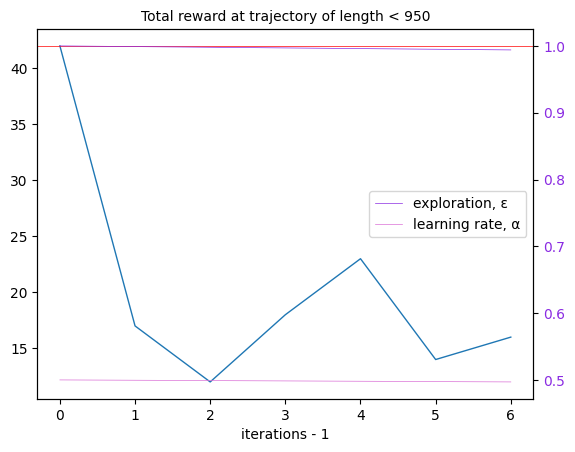

KeyboardInterrupt: 

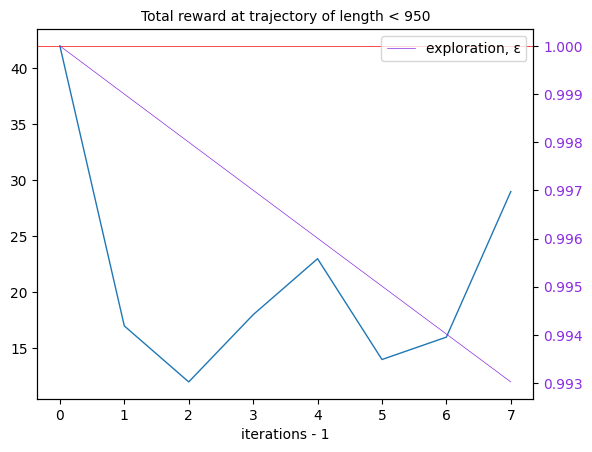

In [6]:
sarsa = SARSAAgent(env=ENVD, aid_to_str=ENVD.aid_to_str)
ann_sarsa_a = LinearAR(start=0.5)
# ann_sarsa_a = SigmoidalAR(al=1e-1, start=0.6)
# ann_sarsa_e = None
ann_sarsa_e = ExponentialAR(la=1e-3)
# ann_sarsa_e = SigmoidalAR(al=1e-2)
sarsa.fit(n_trajectories=1000, max_length=950, alpha_d=ann_sarsa_a, eps_d=ann_sarsa_e, gamma=0.9999, verbose=True)

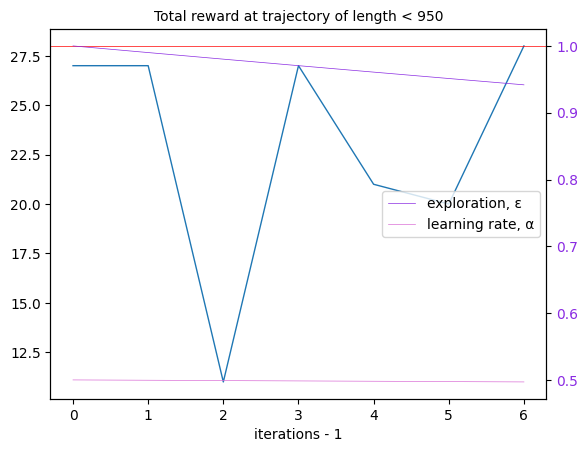

KeyboardInterrupt: 

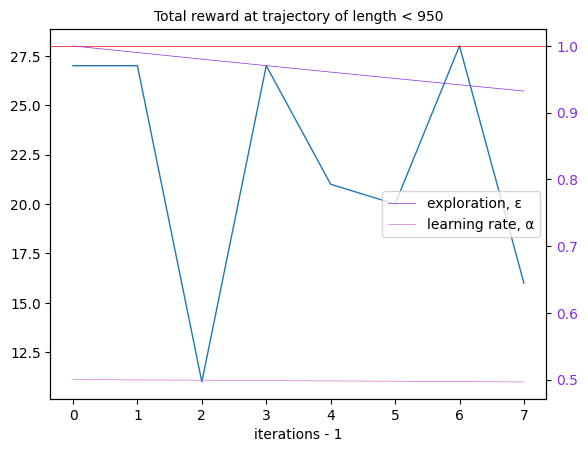

In [7]:
qlr = QLearningAgent(env=ENVD, aid_to_str=ENVD.aid_to_str)
ann_qlr_a = LinearAR(start=0.5)
# ann_qlr_a = ExponentialAR(la=0.1, start=0.8)
# ann_qlr_a = SigmoidalAR(al=1e-2, start=0.5)
ann_qlr_e = ExponentialAR(la=1e-2)
qlr.fit(n_trajectories=1000, max_length=950, alpha_d=ann_qlr_a, eps_d=ann_qlr_e, gamma=0.999, verbose=True)

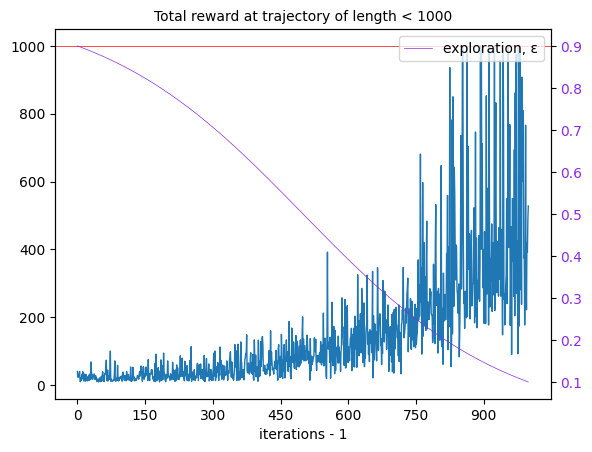

In [38]:
mca = MonteCarloAgent(env=ENVD, aid_to_str=ENVD.aid_to_str)
# ann_mc = None
ann_mc = SigmoidalAR(al=0.1)
# ann_mc = ExponentialAR(la=1e-2)
mca.fit(n_trajectories=1000, max_length=1000, gamma=0.999, eps_d=ann_mc, verbose=True)

In [15]:
class CSRandAgent(RandAgent):
    """baseline agent that performs random discrete actions (continuous environment)"""
    def __init__(self, env, aid_to_str=False, capture_path='./animations'):
        super().__init__(env=env, aid_to_str=aid_to_str, capture_path=capture_path)
        self.n_states = None
        try:
            self.d_states = self.env.observation_space.shape[0]
        else:
            self.d_states = None
        self.policy = None
        
    def act(self, state):
        action = np.random.binomial(n=1, p=0.5, size=1)
        return action
    
    def show_policy(self, label=None):
        return None

In [49]:
class CrossEntropyNNCAgent(CSRandAgent):
    def __init__(self, env, aid_to_str=False, capture_path='./animations', noise_fn=G_noise, hidden_d=(120, None), device=DEVICE):
        """CrossEntropy algorithm actor, optimizes expected reward by policy, given by neural network"""
        super().__init__(env=env, aid_to_str=aid_to_str, capture_path=capture_path)
        
        self.scale = 1
        self.noise_fn = noise_fn
        self.noise = torch.zeros(self.n_actions)
        
        self.loss = nn.CrossEntropyLoss()
        self.device = device
        self.model = nn.Sequential(
            nn.Linear(in_features=self.d_states, out_features=hidden_d[0]),
            nn.ReLU(),
            nn.Linear(hidden_d[0], self.n_actions),
        )
        
    def act(self, state):
        """policy = action given by tanh(network output) + random noise within [0..1] 
            otherwise this policy would be almost completely deterministic (as NN is except its initialization)
            clipper is used instead of tanh due to just to fit result into action space min max limits"""
        with torch.inference_mode():
            self.noise = self.noise_fn(dim=self.n_actions, pr3v=self.noise)
            # action = nn.functional.tanh(self.model(torch.Tensor(state)).detach() + self.scale * self.noise) 
            action_d = self.model(torch.Tensor(state)).detach() + self.scale * self.noise
            action = torch.argmax(action_d)
        return action.numpy()
        
    def fit(self, n_iterations, max_n_epochs, noise_scale_d=None, lr=0.01, n_trajectories=100, max_length=50, q=0.8, verbose=None):
        """
        CE Algorithm has 2 steps per iteration: evaluate policy, improve policy
        Our goal is to maximize expected reward ER which is unreachable => approximated
        
        n_trajectories (w/ length <= max_length) defines quality of ER approximation
        0<q<1 controls rejected quantile of trajectories

        max_n_epochs controls max possible NN training epochs per each iteration

        lr defines learning rate of built-in Adam optimizer
        
        verbose>0 sets up a period of learning process rendering

        NB: .fit internally uses .act method of child class(this), doesn't inherit parental
        """
        self.model.to(self.device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        iterations_pbar = tqdm.trange(n_iterations, position=0, leave=True, colour="#a2d2ff")
        dh = display.display(display_id=True)
        if noise_scale_d is not None:
            noise_scale_d.n_total = n_iterations
        else:
            noise_scale_d = LinearAR(n_iterations=n_trajectories, start=self.scale)    
        scales = []
        for i in iterations_pbar:
            self.model.eval()
            # policy evaluation (act with current policy or sample n_det deterministic from that one)
            trajectories = [self.walk(max_length=max_length) for t in range(n_trajectories)]
            rewards = np.stack([np.sum(t['r']) for t in trajectories])
            avg_reward = np.mean(rewards)
            self.log.append(avg_reward)
            # policy improvement
            # get q-quantile of current reward distribution and filter out better trajectories
            gamma = np.quantile(rewards, q)
            elite_ids = (rewards > gamma).nonzero()[0]
            if elite_ids.any():
                # extract (lists of) state and (corresponding) action tensors from elite trajectories
                states_l, actions_l = zip(*((np.stack(trajectories[ei]['s']), np.stack(trajectories[ei]['a'])) for ei in elite_ids))
                states, actions = torch.Tensor(np.concatenate(states_l)).to(self.device), torch.tensor(np.concatenate(actions_l)).to(self.device)
                epochs_pbar = [0] if (max_n_epochs == 1 or i==0) else tqdm.trange(n_epochs, position=1, leave=False, colour="#ffc8dd") # order matters
                self.model.train()
                for e in epochs_pbar:
                    # forward pass
                    pred_actions_d = self.model(states)
                    loss = self.loss(pred_actions_d, actions)
                    # backward pass
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                # decrease noise scale
                self.scale = noise_scale_d(i)
                scales.append(self.scale)
                # less stochastic gradients (ascending from 1 to max_n_epochs)
                n_epochs_d = ExponentialAR(la=2/n_iterations, start=1, drop=None)
                n_epochs = 1 + round((1 - n_epochs_d(i)) * (max_n_epochs - 1))
                iterations_pbar.set_postfix_str(f'avg reward: {avg_reward.item():.2f}, loss: {loss.detach().item():.2e}, scaled_noise: {torch.mean(self.scale*self.noise).item():.2f}, n_epochs: {n_epochs}', refresh=True)
            
            # visualization (plotting starts after at least 1 iteration)
            if verbose and i > 0 and (i + 1) % verbose == 0:
                # print(f"iteration {i + 1}, mean total reward: {avg_reward}")
                figure, axes = plt.subplots(1, 2, figsize=(12,5))
                ax = self.learning_curve(ax=axes[0], title="Mean rewards")
                
                ax2 = ax.twinx()
                ax2.tick_params(axis='y', labelcolor='slateblue')
                sns.lineplot(scales, linewidth=0.5, ax=ax2, label="noise scale", color='slateblue')
                
                ax = sns.histplot(rewards, kde=False, bins=20, ax=axes[1])
                ax.axvline(gamma, 0, 20, color='r')
                ax.set_xlabel('Rewards')
                ax.set_title(f'Current distribution of rewards and its {q:.2f}-quantile ', fontsize = 10)
                
                dh.update(plt.gcf())
                plt.close() # because plt.clf() is spurious
        return avg_reward

  0%|          | 0/100 [00:00<?, ?it/s]

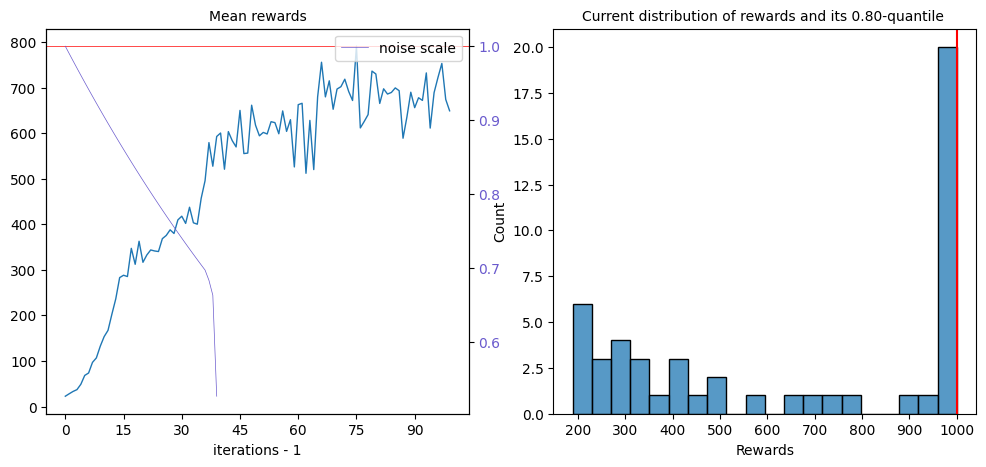

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

648.98

In [60]:
agent_nnc = CrossEntropyNNCAgent(env=ENVD.e, aid_to_str=ENVD.aid_to_str, noise_fn=G_noise)
# ann_nnc_n = LinearAR(start=2)
ann_nnc_n = ExponentialAR(la=0.01, start=2, drop=1e-5)
# ann_nnc_n = SigmoidalAR(al=1e-1, start=2)
agent_nnc.fit(n_iterations=100, max_n_epochs=10, noise_scale_d=ann_nnc_n, lr=0.01, n_trajectories=50, max_length=1000, q=0.8, verbose=1)